In [1]:
from tmm_torch import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
import json
from arch.HybridNet import HybnetLoss, HybnetLoss_plus
import scipy.io as sio
import tqdm

device_train = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_test = torch.device("cpu")

runs = []

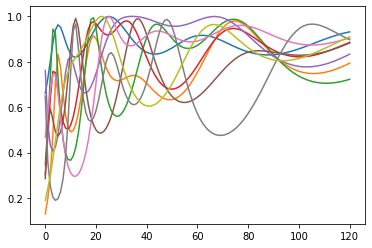

In [9]:
mat = sio.loadmat(r'results\Test_13_43.01_0.946_params.mat')
params = mat['params']
responses = mat['responses']
for i in range(responses.shape[0]):
    plt.plot(responses[i, :])
plt.show()

In [6]:
mat['params'].sum(axis=1)

array([574.63696, 591.5638 , 603.65955, 570.6694 , 625.4057 , 606.6808 ,
       616.188  , 651.36816, 564.82385], dtype=float32)

In [2]:
fnet_folder = Path(r'D:\zf-py\graduate2\PCSED\nets\fnet\TMM_L20_R5.0')
fnet:TMM_predictor = torch.load(fnet_folder/'fnet.pkl')
fnet.eval()
fnet.to(device_train)
with open(fnet_folder/'config.json') as f:
    fnet_config = json.load(f)['fnet']

WL = np.arange(fnet_config['StartWL'], fnet_config['EndWL'], fnet_config['Resolution'])
WL = torch.from_numpy(WL).float()

params_min = torch.tensor([fnet_config['params_min']]).cuda()
params_max = torch.tensor([fnet_config['params_max']]).cuda()

params = torch.tensor([[50.]*20]*9)
params += torch.randn_like(params)*5
params = params.to(device_train)
params.requires_grad = True



loss_fcn = HybnetLoss_plus()

def stability_loss(params, result):
    min_curve = torch.ones_like(target)
    max_curve = torch.zeros_like(target)
    

target_params = torch.rand(9,20, device=device_train)*(params_max-params_min) + params_min
# target_params = target_params
target = fnet(target_params)
# target[:,40:80] = 0.8
# target[:,10:20] = 0.8
# target = target.to(device_train)

optimizer = optim.Adam([params], lr=1)
# schuduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

schuduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000, 0.001)

def decorr(D):
    D = D / torch.norm(D, dim=(0,1))
    gram = torch.matmul(D.T, D)
    rloss = torch.mean((gram - torch.eye(gram.size(0), device=gram.device))**2)
    return rloss



tensor([0.3447, 0.4015, 0.4968, 0.3809, 0.3605, 0.4806, 0.3789, 0.2765, 0.4057],
       device='cuda:0')

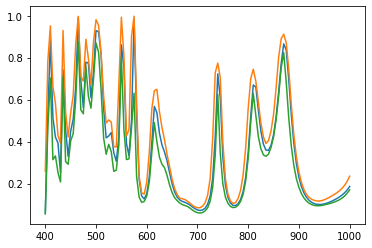

In [5]:
with torch.no_grad():
    params = torch.rand_like(params)*(params_max-params_min)+params_min
    result = fnet(params)
    plt.plot(WL, result[0].detach().cpu().numpy())
    min_curve = torch.ones_like(target).cuda()
    max_curve = torch.zeros_like(target).cuda()
    for i in range(100):
        _params = params + torch.randint_like(params, -2, 2)
        _result = fnet(_params)
        min_curve = torch.min(min_curve, _result)
        max_curve = torch.max(max_curve, _result)
    plt.plot(WL, max_curve[0].detach().cpu().numpy())
    plt.plot(WL, min_curve[0].detach().cpu().numpy())

(max_curve - min_curve).sum(dim=1)/result.sum(dim=1)

In [8]:
loss_history = []
grad_history = []
params_history = []
for i in tqdm.trange(100):
    optimizer.zero_grad()
    output = fnet(params)
    loss = loss_fcn(output, output, params, params_min.to(device_train), params_max.to(device_train), 1, responses=output)
    # loss = decorr(output)
    # print(loss)
    loss.backward()
    loss_history.append(loss.detach().cpu().numpy())
    grad_history.append(params.grad.detach().cpu().numpy())
    params_history.append(params.detach().cpu().numpy())
    optimizer.step()
    schuduler.step()

loss_history = np.array(loss_history)
grad_history = np.array(grad_history)

100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


In [9]:
params.sum(dim=1)

tensor([1598.0908, 1606.2648, 1144.7915, 1578.3602, 1133.1991, 1314.0884,
        1258.3806, 1439.7466, 1384.2527], device='cuda:0',
       grad_fn=<SumBackward1>)

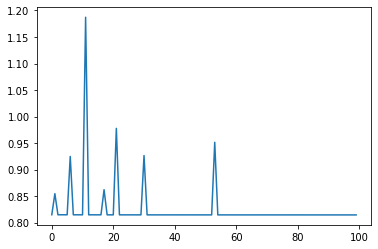

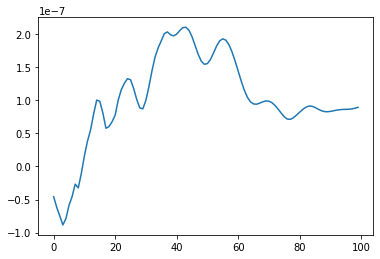

In [10]:
plt.plot(loss_history)
plt.show()
plt.plot(grad_history[:,0,0])
plt.show()

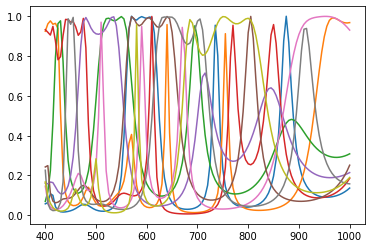

In [12]:
for i in range(9):
    plt.plot(WL, output[i].detach().cpu().numpy())
    # plt.plot(WL, target[i].detach().cpu().numpy())
plt.show()



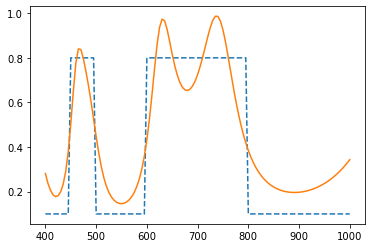

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
runs.append(output.detach().cpu().numpy()[0])
for i in range(A.shape[0]):
    plt.plot(WL, target.detach().cpu().numpy()[i],'--')
    for r in runs:
        plt.plot(WL, r)
    plt.show()

In [ ]:
params.dtype

torch.float32

In [ ]:
params.real

tensor([[20.5271, 68.2896, 84.6737, 10.7235, 12.8415, 10.9462, 74.0193, 73.2942,
         10.9912, 16.6542, 86.0617, 10.1721, 10.7778, 49.0923, 19.0699, 59.5043,
         94.1645, 11.4181, 23.0081, 72.3005]], device='cuda:0',
       requires_grad=True)

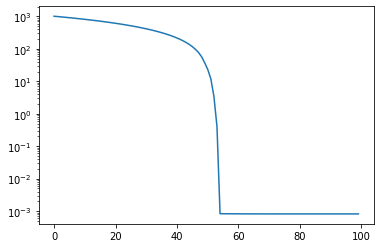

In [7]:
# plot loss with log scale
plt.plot(loss_history)
plt.yscale('log')

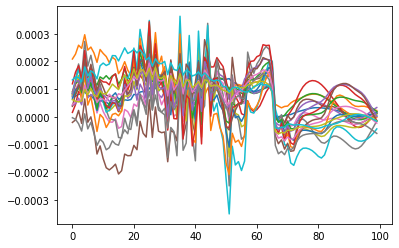

In [10]:
grad_history = np.array(grad_history).transpose(1,2,0)[0]
# plot grad
for i in range(20):
    plt.plot(grad_history[i])


In [ ]:
# using nelder-mead method to optimize
from scipy.optimize import minimize
def loss_func(params):
    params = torch.tensor([params])
    params = params.to(device_train)
    params.requires_grad = True
    output_nm = fnet(params)
    loss = loss_fcn(target, output_nm, params, params_min.to(device_train), params_max.to(device_train), 1e-3)
    return loss.item()

params_nm = np.array([40.]*20)
params_nm += np.random.randn(20)*5
params_nm = params_nm.astype(np.float64)

res = minimize(loss_func, params.detach().cpu().numpy(),method='L-BFGS-B', tol=1e-6, options={'disp': True})
res.x
params_nm


C:\Users\Nightsky\AppData\Local\Temp\ipykernel_48020\1176433928.py:15: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(loss_func, params.detach().cpu().numpy(),method='L-BFGS-B', tol=1e-6, options={'disp': True})


array([32.57689696, 44.52622586, 39.57235115, 35.53712567, 47.45669193,
       43.14412021, 34.65707754, 36.55138446, 39.60638318, 39.92458009,
       38.22699136, 42.21874986, 44.99266045, 38.44719905, 40.36871315,
       36.4074459 , 52.6843658 , 47.24432518, 38.28098513, 39.97400783])

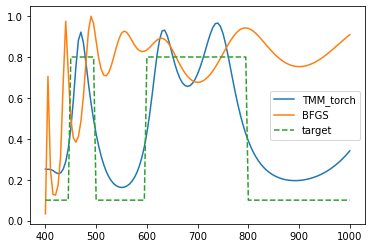

In [ ]:
# compare with the result from fnet
plt.plot(WL, fnet(params).detach().cpu().numpy()[0], label='TMM_torch')
plt.plot(WL, fnet(torch.tensor([params_nm]).cuda()).detach().cpu().numpy()[0], label='BFGS')
plt.plot(WL, target.detach().cpu().numpy()[0],'--', label='target')
plt.legend()
plt.show()